In [89]:
import pandas as pd 
import numpy as np 
import os
import plotly.express as px
import plotly.graph_objects as go
import pickle as pkl
from plotly.subplots import make_subplots
from collections import Counter
from Bio.PDB import PDBParser

In [129]:
cf_colors = {"No cofactor": "#bebdbd", "Other cofactor": "gray", "ADP/ATP": "#1980ed", "Coenzyme A": "#2ca02c", "FAD/FMN": "#d62728", "GDP/GTP": "#9467bd",
             "Heme": "#f0e442", "NAD(P)": "#FF9900", "Inorganic ion": "#990099", "AA derivative": "#fc427b",
             "Vitamin B": "#109618"}

cf_map = {"No cofactor": "No cofactor", "Other cofactor": "Other cofactor", "CHEBI:25524": "NAD(P)", "CHEBI:61296": "ADP/ATP", "CHEBI:61292": "GDP/GTP",
          "CHEBI:36981": "FAD/FMN", "CHEBI:176783": "Other cofactor", "CHEBI:75769": "Vitamin B",
          "CHEBI:83821": "AA derivative", "CHEBI:30413": "Heme", "CHEBI:15346": "Coenzyme A", 
        "CHEBI:26191": "Other cofactor", "CHEBI:36914": "Inorganic ion"}

class_map = {"CHEBI:16646": "Carbohydrate & derivatives", "CHEBI:63299": "Carbohydrate & derivatives", "CHEBI:167559": "Glycan", "CHEBI:37163": "Glycan",
              "CHEBI:35381": "Monosaccharide & derivatives", "CHEBI:63367": "Monosaccharide & derivatives", "CHEBI:15841": "Oligo- & polypeptide",
              "CHEBI:25676": "Oligo- & polypeptide", "CHEBI:33709": "AA & derivatives", "CHEBI:35238": "AA & derivatives",
              "CHEBI:83821": "AA & derivatives", "CHEBI:16991": "Nucleic acid", "CHEBI:33697": "Nucleic acid", "CHEBI:18282": "Nucleobase/nucleoside/nucleotide",
              "CHEBI:33838": "Nucleobase/nucleoside/nucleotide", "CHEBI:36976": "Nucleobase/nucleoside/nucleotide", "CHEBI:18059": "Lipid",
              "CHEBI:36914": "Inorganic ion", "CHEBI:24867": "Inorganic ion", "CHEBI:30413": "Heme", "CHEBI:33733": "Hetero nuclear cluster",
              "Other compound": "Other compound"}

class_color = {"No known ligand": "#C7C7C7", "Other compound": "gray", "Several ligands": "#343534", "Monosaccharide & derivatives": "#AA0DFE", 
                "Glycan": "#800080", "Carbohydrate & derivatives": "#FF00FF", "AA & derivatives": "#00FF00", "Oligo- & polypeptide": "#109618",
                "Nucleobase/nucleoside/nucleotide": "#0000FF", "Nucleic acid": "#40E0D0", "Lipid": "#FF0000", "Inorganic ion": "#FF9DA6",
                "Hetero nuclear cluster": "#FF7F00", "Heme": "#FFFF00"}

king_colors = {"Animalia": "orange", "Plantae": "green", "Fungi": "#57B9FF", "Bacteria": "purple"}

org_map = {"ECOLI": "Bacteria", "YEAST": "Fungi", "CANAL": "Fungi", "ARATH": "Plantae", 
           "MAIZE": "Plantae", "ORYSJ": "Plantae", "SOYBN": "Plantae", "DROME": "Animalia", 
           "CAEEL": "Animalia", "MOUSE": "Animalia", "HUMAN": "Animalia"}

org_colors = {"ECOLI": "#0000FF","YEAST": "gray", "CANAL": "#d62728", "DROME": "#9467bd",
              "ARATH": "#990099", "MAIZE": "black", "ORYSJ": "green", "SOYBN": "brown",
              "CAEEL": "#40E0D0", "MOUSE": "#f0e442", "HUMAN": "#FF9900"}

In [28]:
def get_prot(pocket_id):
    return pocket_id.split("_")[0][3:]


def get_prob(pocket_id): 
    return bs_all.get(pocket_id)["Prob"]


def get_pocket_size(pocket_id):
    return len(bs_all.get(pocket_id)["Res"])


def get_plant_met(prot):
    plant_prot = ['Q84MC7', 'Q8H1R0', 'O49686', 'Q9SSM7', 'Q8VZS8',
                  'Q6EN42']
    if prot in plant_prot:
        return True
    return False


def get_tm_quality(pocket_id):
    prot = pocket_id.split("_")[0][3:] 
    tm_info = tm_all.get(prot)
    if tm_info: 
        return tm_info["num_passed"]
    return tm_info

In [90]:
out_dir= "/home/mpimp-golm.mpg.de/zillmer4400/Desktop/linuxdata/pm_clustering/results/pictures"
ORGANISMS = ["ECOLI", "YEAST", "CANAL", "ARATH", "MAIZE", "ORYSJ", "SOYBN", "DROME", "CAEEL", "MOUSE", "HUMAN"]
PROT_PATH = "../../data/proteins"
RESULTS_PATH = "../../results"
DB_PATH = "../../../Pocketeome/db_files"

SEQ_PATH = "../../results/proteins/seq_len_dict.pkl"
SEQ_DICT = pkl.load(open(SEQ_PATH, "rb"))

FS_PATH = "../../../foldseek/fs_clust_proteins.pkl"
FS_DICT = pkl.load(open(FS_PATH, "rb"))

bs_all = []
dom_all = {}
for org in ORGANISMS:
    bind_dict = pkl.load(open(f"../../results/bind_dict/{org}_pockets.pkl", "rb")) 
    dom_dict = pkl.load(open(f"../../results/pocket_desc/{org}/dom_dict.pkl", "rb"))
    dom_all.update(dom_dict)

    for prot, pockets in list(bind_dict.items()):
        for pocket in pockets: 
            bs_all.append(pocket)
    
df = pd.DataFrame.from_records(bs_all)
df["prot"] = [pocket_id.split("_")[0][3:] for pocket_id in df["pocket_id"]]
df["color_org"] = [org_id if org_id == org else "Other species" for org_id in df["organism"]]
df["domain"] = df["pocket_id"].map(dom_all)
df["num_dom"] = [len(dom["domains"]) for dom in df["domain"]]
df["domain"] = [str(dom["domains"]) for dom in df["domain"]]
df["kingdom"] = df["organism"].map(org_map)
df.head()

,pocket_id,organism,res,seq,prob,plddt,pae,hydro,aro,net_charge,...,cf_class,is_tm,tm_note,tm_evidence,plant_met,prot,color_org,domain,num_dom,kingdom
0,AF-P64578_0,ECOLI,"(47, 49, 50, 51, 52, 53, 59, 61, 65, 68, 88, 9...","[SER, ASP, ASN, PHE, LYS, TYR, VAL, ASN, ASN, ...",0.509,96.397143,1.785714,-1.871,0.214,0.5,...,No cofactor,False,{},{},NaN,P64578,Other species,{'No domain'},1,Bacteria
1,AF-P0A8B2_0,ECOLI,"(101, 102, 103, 130, 131, 132, 133, 134, 135, ...","[HIS, GLY, LEU, MET, HIS, GLY, HIS, GLY, LYS, ...",0.640,94.033125,2.704167,-0.456,0.062,2.0,...,No cofactor,False,{},{},NaN,P0A8B2,Other species,{'Smr domain'},1,Bacteria
2,AF-P39380_0,ECOLI,"(10, 105, 106, 107, 111, 114, 115, 118, 120, 1...","[ALA, HIS, GLY, THR, PHE, GLU, ILE, GLN, LEU, ...",0.962,94.130769,3.647099,-1.095,0.077,5.0,...,No cofactor,False,{},{},NaN,P39380,Other species,{'No domain'},1,Bacteria
3,AF-P0AFP2_0,ECOLI,"(102, 103, 52, 53, 62, 63, 65, 66, 69, 72, 73,...","[ARG, GLN, TYR, GLY, PRO, ARG, ALA, ARG, GLY, ...",0.606,97.018889,1.679739,-1.367,0.111,4.0,...,No cofactor,False,{},{},NaN,P0AFP2,Other species,{'Methylated-DNA-[protein]-cysteine S-methyltr...,1,Bacteria
4,AF-P04846_0,ECOLI,"(113, 138, 139, 142, 184, 203, 205, 206, 230, ...","[PHE, ASN, ASP, ASN, GLU, SER, THR, TYR, ASN, ...",0.725,94.968667,2.409524,-1.040,0.267,-1.5,...,No cofactor,False,{},{},NaN,P04846,Other species,{'No domain'},1,Bacteria


# Domain information 

In [6]:
tmp = df[df["domain"] == "{'No domain'}"]
print(f"Number of pockets that could not be assigned to any domain: {len(tmp)} ({round(len(tmp)/len(df), 3)*100} %)")

Number of pockets that could not be assigned to any domain: 34101 (35.0 %)


In [79]:
tmp = df[df["num_dom"] == 1]
print(f"Number of pockets found in one domain: {len(tmp)}")
count_dom = Counter(tmp["domain"])
count_dom.most_common(30)

Number of pockets found in one domain: 58586


[("{'No domain'}", 34101),
 ("{'Protein kinase domain'}", 4007),
 ("{'GPCR, rhodopsin-like, 7TM'}", 2083),
 ("{'Major facilitator superfamily domain'}", 930),
 ("{'Small GTP-binding domain'}", 665),
 ("{'Kinesin motor domain'}", 584),
 ("{'Haem peroxidase'}", 514),
 ("{'ABC transporter-like, ATP-binding domain'}", 363),
 ("{'PPM-type phosphatase-like domain'}", 308),
 ("{'ABC transporter type 1, transmembrane domain'}", 269),
 ("{'Aldehyde dehydrogenase domain'}", 255),
 ("{'Cation/H+ exchanger, transmembrane domain'}", 248),
 ("{'Serine proteases, trypsin domain'}", 238),
 ("{'Ion transport domain'}", 212),
 ("{'Nuclear hormone receptor, ligand-binding domain'}", 194),
 ("{'Alpha/beta hydrolase fold-1'}", 184),
 ("{'Cytochrome b561/ferric reductase transmembrane'}", 183),
 ("{'Cyclophilin-type peptidyl-prolyl cis-trans isomerase domain'}", 153),
 ("{'Tubulin/FtsZ, GTPase domain'}", 145),
 ("{'Glycoside hydrolase family 16'}", 137),
 ("{'GNAT domain'}", 135),
 ("{'Glycoside hydrolase f

In [7]:
tmp = df[df["num_dom"] > 1]
print(f"Number of pockets found in more than one domain: {len(tmp)}")

no_dom = 0
for dom in tmp["domain"]: 
    if "No domain" in dom: 
        no_dom += 1
print(f"Number of pockets at the domain-no-domain interface: {no_dom}")

tmp = df[df["num_dom"] > 2]
print(f"Number of pockets found in more than two domains: {len(tmp)}")

df["DUF"] = [True if "DUF" in dom else False for dom in df["domain"]]
tmp = df[df["DUF"]]
print(f"Number of pockets found in DUF domains: {len(tmp)}")

Number of pockets found in more than one domain: 38929
Number of pockets at the domain-no-domain interface: 32098
Number of pockets found in more than two domains: 9979
Number of pockets found in DUF domains: 583


In [11]:
df["num_res"] = [len(res) for res in df["res"]]
df["num_res"].median()

24.0

In [138]:
all_communities = pkl.load(open(f"{out_dir}/REVISION/all_communities.pkl", "rb"))
for org, communities in all_communities.items():
    for i in [0, 1]:
        is_kinase = 0
        for pocket_id in communities[i]:
            domains = dom_all.get(pocket_id)["domains"]
            for dom in domains:
                if "protein kinase domain" in dom.lower():
                    is_kinase += 1
        print(f"Percent of kinase pockets in community {i} (n={len(communities[i])}) of {org}: {round(is_kinase/len(communities[i])*100, 2)} %")

Percent of kinase pockets in community 0 (n=110) of ECOLI: 0.0 %
Percent of kinase pockets in community 1 (n=65) of ECOLI: 0.0 %
Percent of kinase pockets in community 0 (n=137) of YEAST: 0.0 %
Percent of kinase pockets in community 1 (n=128) of YEAST: 83.59 %
Percent of kinase pockets in community 0 (n=126) of CANAL: 0.0 %
Percent of kinase pockets in community 1 (n=106) of CANAL: 83.02 %
Percent of kinase pockets in community 0 (n=897) of ARATH: 95.88 %
Percent of kinase pockets in community 1 (n=459) of ARATH: 0.0 %
Percent of kinase pockets in community 0 (n=933) of ORYSJ: 90.03 %
Percent of kinase pockets in community 1 (n=629) of ORYSJ: 0.0 %
Percent of kinase pockets in community 0 (n=1100) of MAIZE: 96.09 %
Percent of kinase pockets in community 1 (n=797) of MAIZE: 0.0 %
Percent of kinase pockets in community 0 (n=1883) of SOYBN: 96.39 %
Percent of kinase pockets in community 1 (n=907) of SOYBN: 0.0 %
Percent of kinase pockets in community 0 (n=260) of DROME: 66.15 %
Percent of

In [32]:
from collections import Counter
for org in ["MOUSE"]:
    communities = all_communities[org]
    for i in [0, 1, 2, 3]:
        dom_count = Counter()
        for pocket_id in communities[i]:
            domains = dom_all.get(pocket_id)["domains"]
            domains = str(domains)
            dom_count[domains] += 1
        most_common = dom_count.most_common(3)
        print(f"Most common domains in community {i} of {org}: {most_common}")

Most common domains in community 0 of MOUSE: [("{'GPCR, rhodopsin-like, 7TM'}", 1032), ("{'No domain'}", 34), ("{'No domain', 'GPCR, rhodopsin-like, 7TM'}", 7)]
Most common domains in community 1 of MOUSE: [("{'No domain', 'GPCR, rhodopsin-like, 7TM'}", 1051), ("{'No domain'}", 8)]
Most common domains in community 2 of MOUSE: [("{'Small GTP-binding domain'}", 98), ("{'No domain'}", 58), ("{'Kinesin motor domain'}", 44)]
Most common domains in community 3 of MOUSE: [("{'Protein kinase domain'}", 226), ("{'No domain', 'Protein kinase domain'}", 145), ("{'AGC-kinase, C-terminal', 'Protein kinase domain'}", 34)]


In [139]:
org = "ECOLI"
dom_of_interest = "ABC transporter-like, ATP-binding domain"
communities = all_communities[org]
for i in [0, 1]:
    is_kinase = 0
    for pocket_id in communities[i]:
        domains = dom_all.get(pocket_id)["domains"]
        for dom in domains:
            if dom == dom_of_interest:
                is_kinase += 1
    print(f"Pockets {dom_of_interest} in community {i} (n={len(communities[i])}) of {org}: {is_kinase}")
    print(f"Percent of {dom_of_interest} in community {i} of {org}: {round(is_kinase/len(communities[i])*100, 2)} %")

Pockets ABC transporter-like, ATP-binding domain in community 0 (n=110) of ECOLI: 74
Percent of ABC transporter-like, ATP-binding domain in community 0 of ECOLI: 67.27 %
Pockets ABC transporter-like, ATP-binding domain in community 1 (n=65) of ECOLI: 0
Percent of ABC transporter-like, ATP-binding domain in community 1 of ECOLI: 0.0 %


# Known pockets 

In [116]:
known_pockets = pkl.load(open("../../data/known_pockets/known_pockets_up.pkl", "rb"))
new = {}
for key, val in known_pockets.items(): 
    if val:
        for idx, pocket in enumerate(val):
            
            new[f"{key}_{idx}"] = pocket

known_pockets = pd.DataFrame.from_dict(new, orient="index")
known_pockets["num_res"] = [len(res) for res in known_pockets["res"]]
# known_pockets["lig id"] = known_pockets["ligand"]
# known_pockets["class_name"] = known_pockets["lig_class"].map(class_map)
# known_pockets["new_lig"] = [get_chebi(chebi, class_ids) for chebi in known_pockets["ligand"]]
known_pockets.head()

,org,ligand,lig_name,res,cf,evidence,found,prob,is_inter,EC,lig_class,class_name,jacc,num_res
P0A9U1_0,ECOLI,CHEBI:30616,ATP,"[40, 41, 42, 43, 44, 45, 46, 47]",CHEBI:61296,ECO:0000255,True,0.206,False,No EC,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.50,8
P0A9U1_1,ECOLI,CHEBI:30616,ATP,"[362, 363, 364, 365, 366, 367, 368, 369]",CHEBI:61296,ECO:0000255,True,0.649,False,No EC,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.62,8
P0ABS1_0,ECOLI,CHEBI:29105,Zn(2+),"[114, 117, 135, 138]",CHEBI:36914,ECO:0000255,True,0.010,False,No EC,CHEBI:24867,Inorganic ion,0.25,4
P0A836_0,ECOLI,CHEBI:30616,ATP,"[46, 53, 54, 55, 99, 102, 107]",CHEBI:61296,ECO:0000255,True,0.968,False,EC 6.-.-.-,CHEBI:36976,Nucleobase/nucleoside/nucleotide,1.00,7
P60785_0,ECOLI,CHEBI:37565,GTP,"[14, 15, 16, 17, 18, 19, 131, 132, 133, 134]",No cofactor,ECO:0000255,True,0.490,False,EC 3.-.-.-,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.10,10


In [120]:
pockets_all = []
for org in ORGANISMS:
    pockets = pkl.load(open(f"../../results/all_pockets/{org}_pockets.pkl", "rb"))
    for prot, pocket_list in pockets.items():
        for pocket in pocket_list:
            pockets_all.append(pocket)
pockets_all = pd.DataFrame.from_records(pockets_all)
pockets_all["prot"] = [pocket_id.split("_")[0][3:] for pocket_id in pockets_all["pocket_id"]]
pockets_all["num_res"] = [len(res) for res in pockets_all["res"]]

In [44]:
med = known_pockets["num_res"].median()
print(f"Median #res for known pockets: {med}")

Median #res for known pockets: 6.0


In [ ]:
tmp = known_pockets[known_pockets["found"] == True]
counts = Counter(tmp["lig_name"])
counts.most_common(20)

0.5


[('ATP', 4811),
 ('GTP', 928),
 ('NAD(+)', 623),
 ('NADP(+)', 494),
 ('S-adenosyl-L-methionine', 468),
 ('FAD', 463),
 ('Zn(2+)', 306),
 ('Mn(2+)', 290),
 ('Fe cation', 202),
 ('UDP-alpha-D-glucose', 140),
 ("pyridoxal 5'-phosphate", 116),
 ('FMN', 112),
 ('AMP', 110),
 ('acetyl-CoA', 106),
 ('a divalent metal cation', 105),
 ("3'-phosphoadenylyl sulfate", 100),
 ('Ca(2+)', 98),
 ('Mg(2+)', 86),
 ('a beta-D-glucoside', 83),
 ('glutathione', 75)]

In [42]:
count = Counter(known_pockets["lig_name"])
count.most_common(30)

[('ATP', 6327),
 ('Zn(2+)', 3949),
 ('Ca(2+)', 3396),
 ('GTP', 1244),
 ('NAD(+)', 663),
 ('NADP(+)', 579),
 ('FAD', 537),
 ('S-adenosyl-L-methionine', 520),
 ('Mn(2+)', 381),
 ('[4Fe-4S] cluster', 362),
 ('Fe cation', 251),
 ('glutathione', 165),
 ('Mg(2+)', 163),
 ('FMN', 157),
 ('[2Fe-2S] cluster', 150),
 ('UDP-alpha-D-glucose', 144),
 ('AMP', 138),
 ('acetyl-CoA', 126),
 ("pyridoxal 5'-phosphate", 124),
 ('a divalent metal cation', 121),
 ("3'-phosphoadenylyl sulfate", 106),
 ('CoA', 92),
 ('a beta-D-glucoside', 84),
 ('L-glutamate', 73),
 ('chlorophyll a', 63),
 ('ADP', 59),
 ('K(+)', 53),
 ('2-oxoglutarate', 52),
 ('Na(+)', 51),
 ('D-glyceraldehyde 3-phosphate', 42)]

In [99]:
counter = Counter(known_pockets["class_name"])
num_dict = {lig_class: f"{lig_class} ({num})" for lig_class,num in counter.items()}
class_color2 = {num_dict.get(lig_class): color for lig_class, color in class_color.items() if lig_class in num_dict}

In [117]:
count = Counter(known_pockets["lig_class"])
count

Counter({'CHEBI:36976': 10154,
         'CHEBI:24867': 8418,
         'Other compound': 1410,
         'CHEBI:83821': 60,
         'CHEBI:18059': 267,
         'CHEBI:33709': 192,
         'CHEBI:16646': 18,
         'CHEBI:33733': 517,
         'CHEBI:25676': 168,
         'CHEBI:36914': 38,
         'CHEBI:63299': 633,
         'CHEBI:18282': 4,
         'CHEBI:35381': 92,
         'CHEBI:63367': 13,
         'CHEBI:35238': 143,
         'CHEBI:30413': 13,
         'CHEBI:33838': 15,
         'CHEBI:37163': 41,
         'CHEBI:16991': 7,
         'CHEBI:15841': 3})

In [124]:
for th in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    num_pockets = len(pockets_all[(pockets_all["prob"] >= th)])
    n_found = len(known_pockets[(known_pockets["prob"] >= th) & (known_pockets["found"] == True)])
    not_found = len(known_pockets) - n_found
    print(f"Threshold: {th}, Found: {n_found}, Not found: {not_found}, Ratio: {round(n_found/len(known_pockets), 3)}, # pred. pockets: {num_pockets}")

Threshold: 0, Found: 16364, Not found: 5842, Ratio: 0.737, # pred. pockets: 715522
Threshold: 0.1, Found: 14060, Not found: 8146, Ratio: 0.633, # pred. pockets: 265067
Threshold: 0.2, Found: 13104, Not found: 9102, Ratio: 0.59, # pred. pockets: 176156
Threshold: 0.3, Found: 12498, Not found: 9708, Ratio: 0.563, # pred. pockets: 137531
Threshold: 0.4, Found: 12027, Not found: 10179, Ratio: 0.542, # pred. pockets: 114730
Threshold: 0.5, Found: 11540, Not found: 10666, Ratio: 0.52, # pred. pockets: 97515
Threshold: 0.6, Found: 10943, Not found: 11263, Ratio: 0.493, # pred. pockets: 81068
Threshold: 0.7, Found: 10030, Not found: 12176, Ratio: 0.452, # pred. pockets: 66346
Threshold: 0.8, Found: 8452, Not found: 13754, Ratio: 0.381, # pred. pockets: 50381
Threshold: 0.9, Found: 5371, Not found: 16835, Ratio: 0.242, # pred. pockets: 29361


In [119]:
known_pockets[(known_pockets["found"] == True) & (known_pockets["prob"] >= 0.5)]

,org,ligand,lig_name,res,cf,evidence,found,prob,is_inter,EC,lig_class,class_name,jacc,num_res
P0A9U1_1,ECOLI,CHEBI:30616,ATP,"[362, 363, 364, 365, 366, 367, 368, 369]",CHEBI:61296,ECO:0000255,True,0.649,False,No EC,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.62,8
P0A836_0,ECOLI,CHEBI:30616,ATP,"[46, 53, 54, 55, 99, 102, 107]",CHEBI:61296,ECO:0000255,True,0.968,False,EC 6.-.-.-,CHEBI:36976,Nucleobase/nucleoside/nucleotide,1.00,7
P0AFQ7_0,ECOLI,CHEBI:60240,a divalent metal cation,"[7, 9, 94, 205]",No cofactor,ECO:0000269,True,0.886,False,EC 3.-.-.-,CHEBI:24867,Inorganic ion,0.75,4
P31553_0,ECOLI,CHEBI:16347,(R)-carnitine,"[327, 328, 329, 330]",No cofactor,ECO:0000269,True,0.983,False,No EC,CHEBI:83821,AA & derivatives,0.50,4
P76187_0,ECOLI,CHEBI:58349,NADP(+),"[158, 159, 209, 210, 211, 212, 213, 214, 215, ...",CHEBI:25524,ECO:0000269,True,0.700,False,EC 1.-.-.-,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.31,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UIJ7_1,HUMAN,CHEBI:456215,AMP,"[38, 43, 64, 65, 66, 91, 92, 93, 94, 98, 161, ...",CHEBI:61296,ECO:0000255,True,0.990,False,EC 2.-.-.-,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.92,12
Q9UHD8_0,HUMAN,CHEBI:37565,GTP,"[305, 306, 307, 308, 309, 310, 311, 312, 339, ...",No cofactor,ECO:0000250,True,0.579,False,No EC,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.57,21
Q9Y5S8_0,HUMAN,CHEBI:57692,FAD,"[338, 339, 340, 341, 342, 343, 344]",CHEBI:36981,ECO:0000255,True,0.948,False,EC 1.-.-.-,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.14,7
P62333_0,HUMAN,CHEBI:30616,ATP,"[174, 175, 176, 177, 178, 179, 180, 181]",CHEBI:61296,ECO:0000255,True,0.886,False,No EC,CHEBI:36976,Nucleobase/nucleoside/nucleotide,0.88,8


/tmp/ipykernel_13926/1121940884.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0, 'Nucleobase/nucleoside/nucleotide'),
 Text(1, 0, 'Inorganic ion'),
 Text(2, 0, 'Other compound'),
 Text(3, 0, 'AA & derivatives'),
 Text(4, 0, 'Lipid'),
 Text(5, 0, 'Carbohydrate & derivatives'),
 Text(6, 0, 'Hetero nuclear cluster'),
 Text(7, 0, 'Oligo- & polypeptide'),
 Text(8, 0, 'Monosaccharide & derivatives'),
 Text(9, 0, 'Heme'),
 Text(10, 0, 'Glycan'),
 Text(11, 0, 'Nucleic acid')]

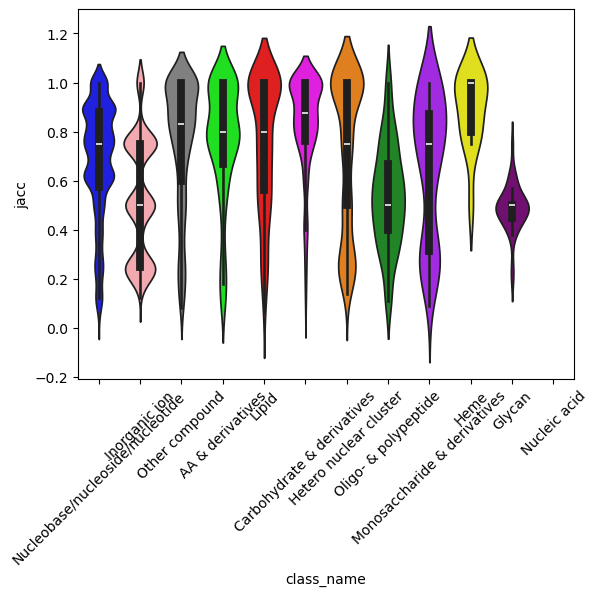

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
sns.violinplot(x="class_name", y="jacc", hue="class_name", data=known_pockets, palette=class_color, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


In [100]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]], subplot_titles=["<b>Found</b>", "<b>Not found</b>"])

tmp = known_pockets[(known_pockets["found"] == True) & (known_pockets["prob"] >= 0.5)]
count_dict = Counter(tmp["class_name"])
count_df = pd.DataFrame(list(zip(count_dict.keys(), count_dict.values())), columns = ["lig_class", "count"])
count_df["colors"] = count_df["lig_class"].map(class_color)
count_df["legend"] = count_df["lig_class"].map(num_dict)
labels = [lig_class for lig_class in class_color2.keys()]
vals = [count_dict.get(lig_class, 0) for lig_class in class_color.keys() if lig_class in num_dict]
fig.add_trace(go.Pie(labels=labels, values=vals), row=1, col =1)

tmp = known_pockets[(known_pockets["found"] == False) | (known_pockets["prob"] < 0.5)]
count_dict = Counter(tmp["class_name"])
labels = [lig_class for lig_class in class_color2.keys()]
vals = [count_dict.get(lig_class, 0) for lig_class in class_color.keys() if lig_class in num_dict]
fig.add_trace(go.Pie(labels=labels,
                     values=vals,
                     marker=dict(colors=list(class_color2.values()))), row=1, col =2)

fig.update_layout(width = 900, height=350,
                 font=dict(size=12, color="black", family="Arial"),
                 margin=dict(l=20, r=20, t=20, b=10))
fig.update_traces(texttemplate='%{percent:.2%}')
fig.write_image(f"{out_dir}/REVISION/ligands_found_pie.png", scale=1, width=900, height=350)
fig.show()